https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import scikitplot as skplt # pip install scikit-plot
import xgboost as xgb 

#### Q1.

Exploratory analysis of the dataset.

In [2]:
pd.set_option("display.max_columns", None)

df = pd.read_csv("European_bank_marketing.csv")
df.drop(columns='duration', inplace=True) # Drop duration as mentioned in footnotes of assignment outline

term_deposit = df.pop("term_deposit") # reorder dataframe so response variable in final column
df.insert(len(df.columns), 'term_deposit', term_deposit)

df.iloc[np.random.randint(0, len(df), size=20)] # Get 20 random observations from sample

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Ethnicity_African,term_deposit
24983,44,technician,married,professional.course,no,yes,no,cellular,nov,tue,1,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,0,0
24819,35,unemployed,single,basic.6y,unknown,yes,no,cellular,nov,tue,1,999,1,failure,-0.1,93.200,-42.0,4.153,5195.8,0,0
25007,53,admin.,divorced,university.degree,no,yes,no,cellular,nov,tue,1,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,0,0
6719,44,admin.,single,high.school,no,no,no,telephone,may,wed,3,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
24052,49,blue-collar,married,basic.6y,no,no,no,telephone,oct,wed,1,999,0,nonexistent,-0.1,93.798,-40.4,4.827,5195.8,0,0
10433,31,blue-collar,married,basic.9y,no,no,no,telephone,jun,mon,21,999,0,nonexistent,1.4,94.465,-41.8,4.960,5228.1,0,0
2044,43,management,married,basic.6y,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
25216,53,entrepreneur,married,basic.9y,no,yes,no,cellular,nov,tue,2,999,1,failure,-0.1,93.200,-42.0,4.153,5195.8,0,0
39456,37,admin.,married,university.degree,no,yes,yes,cellular,apr,thu,1,999,0,nonexistent,-1.8,93.749,-34.6,0.644,5008.7,0,1
3851,37,admin.,married,high.school,no,no,yes,telephone,may,fri,2,999,0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,0,0


In [3]:
df.drop('Ethnicity_African', axis=1, inplace=True)

In [4]:
mean = df.mean(numeric_only=True)
median = df.median(numeric_only=True)
std = df.std(numeric_only=True)

desc_stats = pd.DataFrame([mean, median, std], index=['mean', 'median', 'std. dev'])
desc_stats

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,term_deposit
mean,40.02406,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654
median,38.00000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
std. dev,10.42125,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173


Look at counts for each category in our categorical variables.

In [5]:
df_agg = df.groupby("job").mean()
df_agg.insert(0, 'count', df['job'].value_counts())
df_agg.sort_values('term_deposit')

,count,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,term_deposit
job,,,,,,,,,,,
blue-collar,9254,39.555760,2.558461,985.160363,0.122542,0.248995,93.656656,-41.375816,3.771996,5175.615150,0.068943
services,3969,37.926430,2.587805,979.974049,0.154951,0.175359,93.634659,-41.290048,3.699187,5171.600126,0.081381
entrepreneur,1456,41.723214,2.535714,981.267170,0.138736,0.158723,93.605372,-41.283654,3.791120,5176.313530,0.085165
housemaid,1060,45.500000,2.639623,960.579245,0.137736,0.433396,93.676576,-39.495283,4.009645,5179.529623,0.100000
self-employed,1421,39.949331,2.660802,976.621393,0.143561,0.094159,93.559982,-40.488107,3.689376,5170.674384,0.104856
technician,6743,38.507638,2.577339,964.408127,0.153789,0.274566,93.561471,-39.927569,3.820401,5175.648391,0.108260
unknown,330,45.563636,2.648485,938.727273,0.154545,0.357879,93.718942,-38.797879,3.949033,5172.931818,0.112121
management,2924,42.362859,2.476060,962.647059,0.185021,-0.012688,93.522755,-40.489466,3.611316,5166.650513,0.112175
admin.,10422,38.187296,2.623489,954.319229,0.189023,0.015563,93.534054,-40.245433,3.550274,5164.125350,0.129726


In [6]:
df_agg = df.groupby("marital").mean()
df_agg.insert(0, 'count', df['marital'].value_counts())
df_agg.sort_values('term_deposit')

,count,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,term_deposit
marital,,,,,,,,,,,
married,24928,42.307165,2.57281,967.247673,0.155608,0.183625,93.597367,-40.270659,3.745832,5171.848772,0.101573
divorced,4612,44.899393,2.61340,968.639853,0.168690,0.163985,93.606563,-40.707069,3.715603,5170.878643,0.103209
single,11568,33.158714,2.53380,949.909578,0.211359,-0.167989,93.517300,-40.918698,3.317447,5155.199265,0.140041
unknown,80,40.275000,3.18750,937.100000,0.275000,-0.221250,93.471250,-40.820000,3.313038,5157.393750,0.150000


In [7]:
df_agg = df.groupby("education").mean()
df_agg.insert(0, 'count', df['education'].value_counts())
df_agg.sort_values('term_deposit')

,count,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,term_deposit
education,,,,,,,,,,,
basic.9y,6045,39.061208,2.532341,979.133168,0.141439,0.159239,93.623399,-41.326749,3.697963,5172.294012,0.078246
basic.6y,2292,40.448953,2.556283,980.368237,0.129145,0.231152,93.650062,-41.127880,3.772942,5174.718063,0.082024
basic.4y,4176,47.596504,2.600575,965.704981,0.147031,0.215924,93.658309,-40.239871,3.751768,5170.124880,0.102490
high.school,9515,37.998213,2.568576,964.358382,0.185917,0.032937,93.584857,-40.940641,3.556157,5164.994735,0.108355
professional.course,5243,40.080107,2.586115,960.765974,0.163075,0.173012,93.569864,-40.124108,3.710457,5170.155979,0.113485
university.degree,12168,38.879191,2.563527,951.807692,0.192390,-0.028090,93.493466,-39.975805,3.529663,5163.226298,0.137245
unknown,1731,43.481225,2.596187,942.830734,0.226459,0.059099,93.658615,-39.877816,3.571098,5159.549509,0.145003
illiterate,18,48.500000,2.277778,943.833333,0.111111,-0.133333,93.317333,-39.950000,3.516556,5171.777778,0.222222


In [8]:
df_agg = df.groupby("default").mean()
df_agg.insert(0, 'count', df['default'].value_counts())
df_agg.sort_values('term_deposit')

,count,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,term_deposit
default,,,,,,,,,,,
yes,3,42.333333,1.333333,999.000000,0.333333,0.900000,93.362667,-38.066667,4.693000,5217.333333,0.00000
unknown,8597,43.371990,2.745609,991.606258,0.074096,0.703466,93.765365,-40.265139,4.280654,5193.725951,0.05153
no,32588,39.140635,2.520744,954.787130,0.199030,-0.082168,93.525639,-40.565469,3.447246,5159.990214,0.12879


In [9]:
df_agg = df.groupby("housing").mean()
df_agg.insert(0, 'count', df['housing'].value_counts())
df_agg.sort_values('term_deposit')

,count,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,term_deposit
housing,,,,,,,,,,,
unknown,990,39.951515,2.560606,964.896970,0.184848,0.113434,93.636011,-40.289192,3.653046,5166.457273,0.108081
no,18622,40.044195,2.601010,964.559875,0.161153,0.184089,93.624836,-40.337590,3.732474,5170.661857,0.108796
yes,21576,40.010011,2.539071,960.565304,0.182610,-0.007773,93.530456,-40.654811,3.523873,5163.932949,0.116194


In [10]:
df_agg = df.groupby("loan").mean()
df_agg.insert(0, 'count', df['loan'].value_counts())
df_agg.sort_values('term_deposit')

,count,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,term_deposit
loan,,,,,,,,,,,
unknown,990,39.951515,2.560606,964.896970,0.184848,0.113434,93.636011,-40.289192,3.653046,5166.457273,0.108081
yes,6248,39.846671,2.602273,962.437420,0.170455,0.086316,93.567529,-40.652241,3.619294,5167.754369,0.109315
no,33950,40.058822,2.561414,962.411841,0.173078,0.080150,93.575402,-40.481284,3.620732,5166.920563,0.113402


In [11]:
df_agg = df.groupby("contact").mean()
df_agg.insert(0, 'count', df['contact'].value_counts())
df_agg.sort_values('term_deposit')

,count,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,term_deposit
contact,,,,,,,,,,,
telephone,15044,40.120513,2.850106,991.542874,0.034100,0.896969,94.026993,-38.967469,4.535349,5192.671856,0.052313
cellular,26144,39.968559,2.405026,945.749235,0.252869,-0.387137,93.315957,-41.385959,3.095316,5152.284260,0.147376


In [12]:
df_agg = df.groupby("poutcome").mean()
df_agg.insert(0, 'count', df['poutcome'].value_counts())
df_agg.sort_values('term_deposit')

,count,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,term_deposit
poutcome,,,,,,,,,,,
nonexistent,35563,39.956190,2.664145,999.000000,0.000000,0.377091,93.645708,-40.319045,3.958189,5181.203492,0.088322
failure,4252,39.946143,2.005174,965.976011,1.168627,-1.685442,93.067755,-42.720461,1.651071,5092.589534,0.142286
success,1373,42.023307,1.808449,5.587764,1.569556,-2.091260,93.334355,-38.388565,0.996563,5030.622433,0.651129


In [13]:
df_agg = df.groupby("month").mean()
df_agg.insert(0, 'count', df['month'].value_counts())
df_agg.sort_values('term_deposit')

,count,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,term_deposit
month,,,,,,,,,,,
may,13769,39.031084,2.439756,981.120415,0.164209,-0.164972,93.528882,-40.579272,3.293665,5149.521592,0.064347
jul,7174,39.035545,3.160998,982.700725,0.047115,1.158921,93.894923,-42.370170,4.685678,5214.078575,0.090466
nov,4101,40.965618,1.909290,952.950256,0.293587,-0.418483,93.200943,-41.238747,3.723123,5173.031236,0.101439
jun,5318,39.766077,3.072208,970.221512,0.083114,0.688379,94.245402,-41.579428,4.256908,5197.493193,0.105115
aug,6178,41.644221,2.666559,961.062156,0.115410,0.747151,93.311065,-35.597184,4.300623,5200.248349,0.106021
apr,2632,40.593845,1.947188,955.587386,0.323328,-1.800000,93.119558,-46.273632,1.361070,5093.123708,0.204787
oct,718,44.171309,1.545961,781.909471,0.647632,-2.438579,93.175107,-34.580919,1.200123,5018.823816,0.438719
sep,570,43.621053,1.773684,718.501754,0.831579,-2.177368,93.346474,-33.893158,0.834760,4988.847895,0.449123
dec,182,47.307692,2.159341,748.060440,0.615385,-2.846154,92.715363,-33.708791,0.865319,5031.895604,0.489011


In [14]:
df_agg = df.groupby("day_of_week").mean()
df_agg.insert(0, 'count', df['day_of_week'].value_counts())
df_agg.sort_values('term_deposit')

,count,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,term_deposit
day_of_week,,,,,,,,,,,
mon,8514,40.412497,2.645760,962.852948,0.171012,0.026063,93.577108,-40.877790,3.542196,5164.568393,0.099483
fri,7827,40.177846,2.719944,967.793791,0.177463,0.032337,93.578735,-40.532260,3.566249,5165.109799,0.108087
wed,8134,39.526801,2.449840,962.859970,0.169044,0.166745,93.590225,-40.281387,3.726885,5170.425436,0.116671
tue,8090,40.427441,2.426823,959.715575,0.173053,0.128220,93.577088,-40.034227,3.701038,5168.486094,0.117800
thu,8623,39.591557,2.595268,959.501913,0.174417,0.058460,93.556380,-40.753323,3.574923,5166.662693,0.121188


We have only 18 observations with education level as 'Illiterate'. This is too few to make any statistical inferences and as such, we will simply add these observations to the next lowest level of education, 'basic.4y'.

Similarly, the default variable only has 3 'yes' observations, and as such should be grouped in with the unknown observations. 

*In order to reduce the dimensionality of our dataset once we code the categories as dummy variables, we will also aggregate each of the months into two categories (Summer & Winter) *(maybe not necessary). Correlation with term_deposit seems to be more with lower numbers of observations (people making less calls?) than which month the call takes place in.

In [5]:
df.loc[df['education']=='illiterate', 'education'] = 'basic.4y'
df.loc[df['default']=='yes', 'default'] = 'unknown'

In [6]:
summer = ['may', 'jun', 'jul', 'aug', 'summer']

df.loc[df['month'].isin(summer)==False, 'month'] = 'winter'
df.loc[df['month'].isin(summer), 'month'] = 'summer'
df.rename(columns={"month": "season"}, inplace=True)

Want to convert the education variable to ordinal data.

In [7]:
encoder = OrdinalEncoder(categories = [['unknown', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree']])
df['education'] = encoder.fit_transform(df['education'].values.reshape(-1,1))

Bar plot showing the frequency of observations in the variable of interest 'term_deposit'.

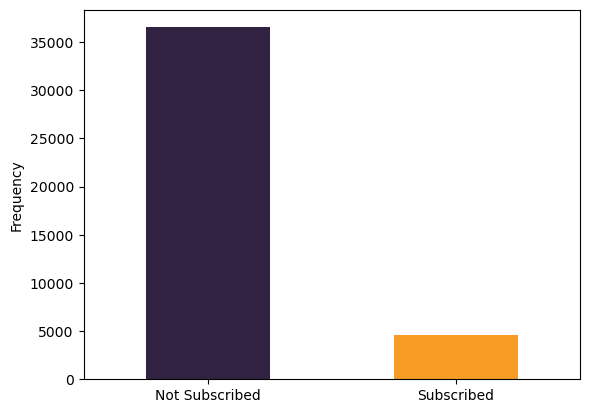

In [8]:
colors = ['#322242', '#f79c25']
ax = df['term_deposit'].value_counts().plot(kind='bar', color=colors)
ax.set_xticklabels(labels=['Not Subscribed', 'Subscribed'], rotation='horizontal')
ax.set_ylabel("Frequency")
plt.show()

Correlation heatmap between each of the numerical variables in our dataset with the variable of interest.

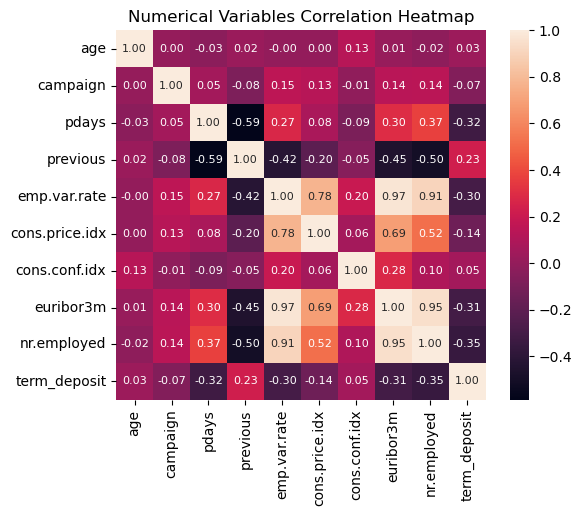

In [9]:
numer_vars = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 
              'cons.conf.idx', 'euribor3m', 'nr.employed', 'term_deposit']

corr_matrix = df[numer_vars].corr()
cols = corr_matrix.columns
hm = sns.heatmap(corr_matrix, cbar=True, annot=True, square=True, fmt='.2f', 
                 annot_kws={'size': 8}, yticklabels=cols, xticklabels=cols, cmap='rocket')
hm.set_title("Numerical Variables Correlation Heatmap")
plt.show()

Relatively low correlation between between our predictor variables, with only. We see that the variables most highly correlated with the variable of interest 'term_deposit' are: 
* pdays
* emp.var.rate
* euribor3m 
* nr.employed 

#### Q2 a)

Fit a logistic regression model on the full set (may want to narrow down) of data.

Create confusion matrices for probability thresholds of 0.1, 0.2, 0.35 & 0.5.

In [10]:
predictors = [column for column in df.columns if column != 'term_deposit']

df_train_X = df[predictors]
df_train_Y = df['term_deposit']
df_train_X = pd.get_dummies(df_train_X, drop_first=True)

logreg = LogisticRegression(max_iter=1000)
model=logreg.fit(df_train_X, df_train_Y)

print(f'Number of iterations before convergence: {model.n_iter_[0]}')
col_names = np.insert(model.feature_names_in_, 0, 'Intercept')
model_coef = np.concatenate(([model.intercept_], model.coef_), axis=1)
pd.DataFrame(model_coef, index=['Beta'], columns=col_names)

Number of iterations before convergence: 274


,Intercept,age,education,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,default_unknown,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,season_winter,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
Beta,0.002359,0.005119,0.020671,-0.04016,-0.002007,-0.306993,-0.171523,0.365021,0.030316,-0.087605,-0.006443,-0.187358,-0.018925,-0.006186,-0.0237,0.117616,-0.004164,-0.084346,0.09529,0.013219,0.005375,-0.003261,-0.086842,0.131443,0.003252,-0.208849,-0.008344,-0.016367,-0.008344,-0.019535,-0.455726,0.268383,-0.191671,0.080995,0.048903,0.102723,0.281419,0.038712


In [21]:
prob_est = model.predict_proba(df_train_X)[:,1]
df_pred = pd.concat([pd.Series(np.zeros(len(df_train_Y), dtype=int), name='classification'), df_train_Y], axis=1)
df_pred.loc[prob_est>0.1, 'classification'] = 1

confusion = pd.DataFrame(np.rot90(confusion_matrix(
    df_pred['term_deposit'], df_pred['classification'], normalize='all'), 2).T)
confusion.columns = pd.MultiIndex.from_tuples([('Actual', 'Subscribed'), ('Actual', 'Not Subscribed')])
confusion.index = pd.MultiIndex.from_tuples([('Predicted', 'Subscribed'), ('Predicted', 'Not Subscribed')])
confusion

Actual               
                         Subscribed Not Subscribed
Predicted Subscribed       0.078057       0.210620
          Not Subscribed   0.034597       0.676726

In [22]:
df_pred = pd.concat([pd.Series(np.zeros(len(df_train_Y), dtype=int), name='classification'), df_train_Y], axis=1)
df_pred.loc[prob_est>0.2, 'classification'] = 1

confusion = pd.DataFrame(np.rot90(confusion_matrix(
    df_pred['term_deposit'], df_pred['classification'], normalize='all'), 2).T)
confusion.columns = pd.MultiIndex.from_tuples([('Actual', 'Subscribed'), ('Actual', 'Not Subscribed')])
confusion.index = pd.MultiIndex.from_tuples([('Predicted', 'Subscribed'), ('Predicted', 'Not Subscribed')])
confusion

Actual               
                         Subscribed Not Subscribed
Predicted Subscribed       0.058124       0.072934
          Not Subscribed   0.054530       0.814412

In [23]:
df_pred = pd.concat([pd.Series(np.zeros(len(df_train_Y), dtype=int), name='classification'), df_train_Y], axis=1)
df_pred.loc[prob_est>0.35, 'classification'] = 1

confusion = pd.DataFrame(np.rot90(confusion_matrix(
    df_pred['term_deposit'], df_pred['classification'], normalize='all'), 2).T)
confusion.columns = pd.MultiIndex.from_tuples([('Actual', 'Subscribed'), ('Actual', 'Not Subscribed')])
confusion.index = pd.MultiIndex.from_tuples([('Predicted', 'Subscribed'), ('Predicted', 'Not Subscribed')])
confusion

Actual               
                         Subscribed Not Subscribed
Predicted Subscribed       0.037851       0.031563
          Not Subscribed   0.074803       0.855783

In [24]:
df_pred = pd.concat([pd.Series(np.zeros(len(df_train_Y), dtype=int), name='classification'), df_train_Y], axis=1)
df_pred.loc[prob_est>0.5, 'classification'] = 1

confusion = pd.DataFrame(np.rot90(confusion_matrix(
    df_pred['term_deposit'], df_pred['classification'], normalize='all'), 2).T)
confusion.columns = pd.MultiIndex.from_tuples([('Actual', 'Subscribed'), ('Actual', 'Not Subscribed')])
confusion.index = pd.MultiIndex.from_tuples([('Predicted', 'Subscribed'), ('Predicted', 'Not Subscribed')])
confusion

Actual               
                         Subscribed Not Subscribed
Predicted Subscribed       0.024643       0.012528
          Not Subscribed   0.088011       0.874818

#### Q2 b)

Fit logistic regression model using a train/test split of 0.7/0.3.

Complete the same steps as above.

In [11]:
df_train_X, df_test_X, df_train_Y, df_test_Y = train_test_split(
    df[predictors], df['term_deposit'], test_size=0.3, random_state=15)

df_train_X = pd.get_dummies(df_train_X, drop_first=True)

logreg = LogisticRegression(max_iter=1000)
model=logreg.fit(df_train_X, df_train_Y)

# print(f'Number of iterations before convergence: {model.n_iter_[0]}')
col_names = np.insert(model.feature_names_in_, 0, 'Intercept')
model_coef = np.concatenate(([model.intercept_], model.coef_), axis=1)
pd.DataFrame(model_coef, index=['Beta'], columns=col_names)

,Intercept,age,education,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,default_unknown,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,season_winter,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
Beta,0.001989,0.003419,0.040728,-0.070294,-0.001645,0.010563,-0.199028,0.148895,0.03382,-0.211379,-0.002466,-0.013699,-0.001269,-0.000667,0.000009,0.006817,-0.000013,-0.00427,0.006424,-0.000506,0.000799,-0.000184,-0.012151,0.015322,0.000133,-0.019439,-0.000369,0.001529,-0.000369,0.000649,-0.031465,0.033971,-0.007562,0.004274,0.002222,0.004419,-0.003426,0.002797


In [12]:
df_test_X = pd.get_dummies(df_test_X, drop_first=True)

prob_est = model.predict_proba(df_test_X)[:,1]
df_pred_test = pd.concat([pd.Series(np.zeros(len(df_test_Y), dtype=int), name='classification'), df_test_Y.reset_index(drop=True)], axis=1)
df_pred_test.loc[prob_est>0.1, 'classification'] = 1

confusion = pd.DataFrame(np.rot90(confusion_matrix(
    df_pred_test['term_deposit'], df_pred_test['classification'], normalize='all'), 2).T)
confusion.columns = pd.MultiIndex.from_tuples([('Actual', 'Subscribed'), ('Actual', 'Not Subscribed')])
confusion.index = pd.MultiIndex.from_tuples([('Predicted', 'Subscribed'), ('Predicted', 'Not Subscribed')])
confusion

Actual               
                         Subscribed Not Subscribed
Predicted Subscribed       0.081978       0.249899
          Not Subscribed   0.030671       0.637452

In [ ]:
df_pred_test = pd.concat([pd.Series(np.zeros(len(df_test_Y), dtype=int), name='classification'), df_test_Y.reset_index(drop=True)], axis=1)
df_pred_test.loc[prob_est>0.2, 'classification'] = 1

confusion = pd.DataFrame(np.rot90(confusion_matrix(
    df_pred_test['term_deposit'], df_pred_test['classification'], normalize='all'), 2).T)
confusion.columns = pd.MultiIndex.from_tuples([('Actual', 'Subscribed'), ('Actual', 'Not Subscribed')])
confusion.index = pd.MultiIndex.from_tuples([('Predicted', 'Subscribed'), ('Predicted', 'Not Subscribed')])
confusion

Actual               
                         Subscribed Not Subscribed
Predicted Subscribed       0.057295       0.072105
          Not Subscribed   0.055353       0.815246

In [ ]:
df_pred_test = pd.concat([pd.Series(np.zeros(len(df_test_Y), dtype=int), name='classification'), df_test_Y.reset_index(drop=True)], axis=1)
df_pred_test.loc[prob_est>0.35, 'classification'] = 1

confusion = pd.DataFrame(np.rot90(confusion_matrix(
    df_pred_test['term_deposit'], df_pred_test['classification'], normalize='all'), 2).T)
confusion.columns = pd.MultiIndex.from_tuples([('Actual', 'Subscribed'), ('Actual', 'Not Subscribed')])
confusion.index = pd.MultiIndex.from_tuples([('Predicted', 'Subscribed'), ('Predicted', 'Not Subscribed')])
confusion

Actual               
                         Subscribed Not Subscribed
Predicted Subscribed       0.030995       0.026786
          Not Subscribed   0.081654       0.860565

In [ ]:
df_pred_test = pd.concat([pd.Series(np.zeros(len(df_test_Y), dtype=int), name='classification'), df_test_Y.reset_index(drop=True)], axis=1)
df_pred_test.loc[prob_est>0.5, 'classification'] = 1

confusion = pd.DataFrame(np.rot90(confusion_matrix(
    df_pred_test['term_deposit'], df_pred_test['classification'], normalize='all'), 2).T)
confusion.columns = pd.MultiIndex.from_tuples([('Actual', 'Subscribed'), ('Actual', 'Not Subscribed')])
confusion.index = pd.MultiIndex.from_tuples([('Predicted', 'Subscribed'), ('Predicted', 'Not Subscribed')])
confusion

Actual               
                         Subscribed Not Subscribed
Predicted Subscribed       0.022174       0.010844
          Not Subscribed   0.090475       0.876507

#### Q2 c)

Plotting ROC Curve for logistic regression model.

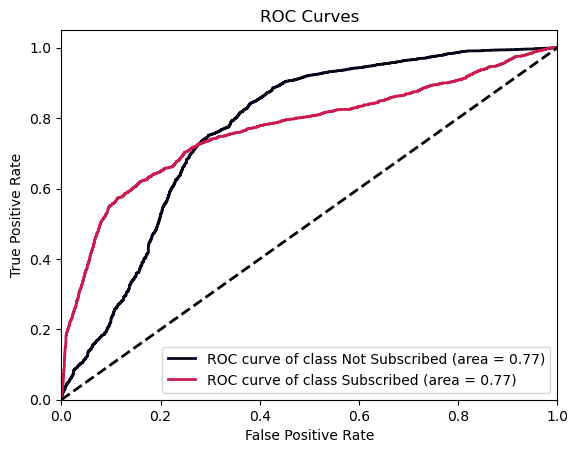

In [13]:
probas_est = model.predict_proba(df_test_X)

labels = df_test_Y.copy()
labels.loc[labels==0] = 'Not Subscribed'
labels.loc[labels==1] = 'Subscribed'

skplt.metrics.plot_roc(labels, probas_est, plot_micro=False, plot_macro=False, cmap='rocket')
plt.show()

In [ ]:
model = xgb.XGBClassifier(objective = 'binary:logistic', colsample_bytree = 0.4, learning_rate = 0.05, 
                            max_depth = 10,  n_estimators = 300, subsample = 0.5)
xgboost = model.fit(df_train_X, df_train_Y)

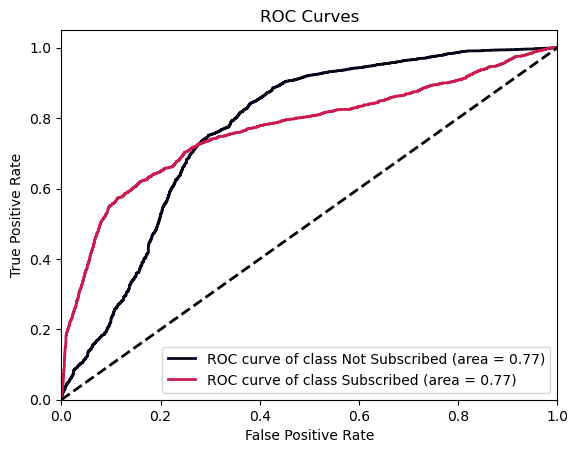

In [14]:
probas_est = model.predict_proba(df_test_X)

labels = df_test_Y.copy()
labels.loc[labels==0] = 'Not Subscribed'
labels.loc[labels==1] = 'Subscribed'

skplt.metrics.plot_roc(labels, probas_est, plot_micro=False, plot_macro=False, cmap='rocket')
plt.show()

In [15]:
xgb.plot_importance(model)
plt.show()

ValueError: tree must be Booster, XGBModel or dict instance

In [ ]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 10],
    'n_estimators': [50, 100, 200]
}

model = xgb.XGBClassifier()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='recall', cv=5, n_jobs=2)
grid_search.fit(df_train_X, df_train_Y)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_:.3f}")

Best parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}
Best score: 0.297


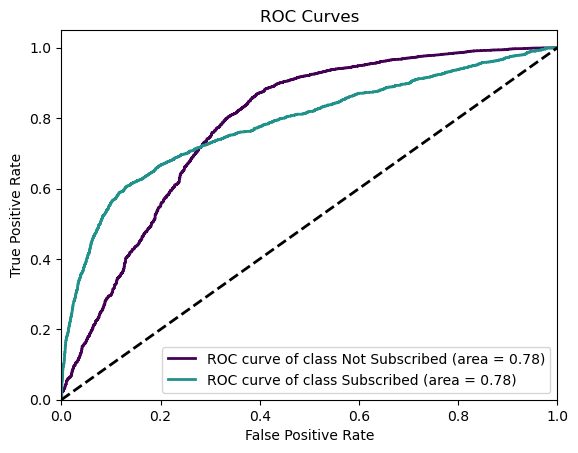

In [ ]:
model = xgb.XGBClassifier(learning_rate=0.1, max_depth = 10, n_estimators=200)
xgboost = model.fit(df_train_X, df_train_Y)

probas_est = model.predict_proba(df_test_X)

labels = df_test_Y.copy()
labels.loc[labels==0] = 'Not Subscribed'
labels.loc[labels==1] = 'Subscribed'

skplt.metrics.plot_roc(labels, probas_est, plot_micro=False, plot_macro=False, cmap='rocket')
plt.show()

In [ ]:
df_pred_test = pd.concat([pd.Series(xgboost.predict(df_test_X), name='classification'), df_test_Y.reset_index(drop=True)], axis=1)

confusion = pd.DataFrame(np.rot90(confusion_matrix(
    df_pred_test['term_deposit'], df_pred_test['classification'], normalize='all'), 2).T)
confusion.columns = pd.MultiIndex.from_tuples([('Actual', 'Subscribed'), ('Actual', 'Not Subscribed')])
confusion.index = pd.MultiIndex.from_tuples([('Predicted', 'Subscribed'), ('Predicted', 'Not Subscribed')])
confusion

Actual               
                         Subscribed Not Subscribed
Predicted Subscribed       0.033503       0.025411
          Not Subscribed   0.079145       0.861941

In [ ]:
# SVM_1 = SVC(kernel='rbf', degree=2, gamma='scale', probability=True)
# model_SVM = SVM_1.fit(df_train_X, df_train_Y)

In [ ]:
# df_test_X = pd.get_dummies(df_test_X, drop_first=True)
# SVM1_prob_est = model_SVM.predict_proba(df_test_X)

# labels = df_test_Y.copy()
# labels.loc[labels==0] = 'Not Subscribed'
# labels.loc[labels==1] = 'Subscribed'

# skplt.metrics.plot_roc(labels, SVM1_prob_est, plot_micro=False, plot_macro=False, cmap='viridis')
# plt.show()

In [ ]:
# SVM_2 = SVC(kernel='rbf', degree=2, gamma='auto', probability=True)
# model_SVM2 = SVM_2.fit(df_train_X, df_train_Y)

In [ ]:
# df_test_X = pd.get_dummies(df_test_X, drop_first=True)
# SVM2_prob_est = model_SVM2.predict_proba(df_test_X)

# labels = df_test_Y.copy()
# labels.loc[labels==0] = 'Not Subscribed'
# labels.loc[labels==1] = 'Subscribed'

# skplt.metrics.plot_roc(labels, SVM2_prob_est, plot_micro=False, plot_macro=False, cmap='rocket')
# plt.show()

In [ ]:
RF = RandomForestClassifier(n_estimators = 100, max_depth=5, criterion='gini')
RF_model = RF.fit(df_train_X, df_train_Y)

In [22]:
RF_prob_est = RF_model.predict_proba(df_test_X)

labels = df_test_Y.copy()
labels.loc[labels==0] = 'Not Subscribed'
labels.loc[labels==1] = 'Subscribed'

skplt.metrics.plot_roc(labels, RF_prob_est, plot_micro=False, plot_macro=False, cmap='rocket')
plt.show()

NameError: name 'RF_model' is not defined

In [ ]:
paramgrid = {
             'n_estimators': [100, 150, 200, 250, 300],
             'criterion': ['gini', 'entropy'],
             'max_depth': [3, 5, 7, 10],
             }

G_CV = GridSearchCV(RF, param_grid=paramgrid, scoring='recall', n_jobs=-1, cv=5)
G_CV.fit(df_train_X, df_train_Y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(max_depth=5), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10],
                         'n_estimators': [100, 150, 200, 250, 300]},
             scoring='recall')

In [ ]:
print(f"Best parameters: {G_CV.best_params_}")
print(f"Best Score: {G_CV.best_score_}")

Best parameters: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100}
Best Score: 0.23923195448619178


Calculation of principal components, with plot of the cumulative proportion of variance explained by each Principal Component.

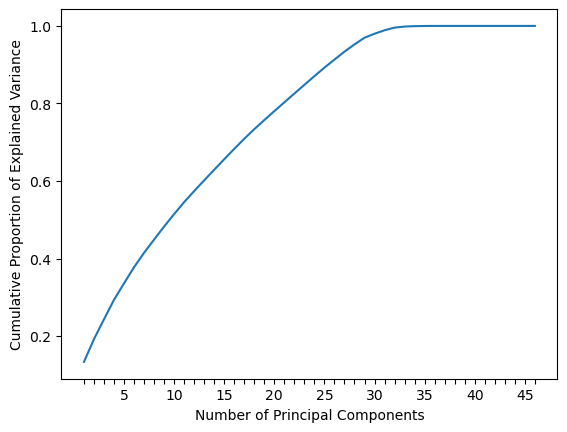

In [16]:
# df_train = pd.get_dummies(df[numer_vars[:-1]])
df_train = pd.get_dummies(df[predictors])

SS = StandardScaler()
scaler = SS.fit(df_train)
df_scaled = scaler.transform(df_train)
df_scaled = pd.DataFrame(df_scaled, columns=df_train.columns)
covar = df_scaled.cov()

u, s, vh = np.linalg.svd(covar)
explained_var = np.zeros(len(s))
for i in range(len(s)):
    explained_var[i] = s[i]/len(s)

fig, ax = plt.subplots()
plt.plot(np.cumsum(explained_var))
ax.set_xticks(range(0,len(s)), labels=range(1,len(s)+1))
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Proportion of Explained Variance")
for i, labels in enumerate(ax.get_xticklabels()):
    if i % 5 == 4:
        continue
    labels.set_visible(False)
plt.show()

As we might have expected from the low correlations seen in the heatmap, not a lot of the variance in the predictor variables is explained by the first few principal components.

Look at the first 4 Principal Components to see which variables they are loaded on.

In [17]:
pd.DataFrame(u[:,0:4], columns=['PC1', 'PC2', 'PC3', 'PC4'], index=df_train.columns)

,PC1,PC2,PC3,PC4
age,-0.009872,-0.324642,0.144349,-0.048249
education,0.055187,0.319865,-0.073642,0.040808
campaign,-0.071899,0.016837,-0.030402,0.011595
pdays,-0.189511,0.176174,0.356710,-0.172529
previous,0.272957,-0.193112,-0.266253,0.113562
emp.var.rate,-0.350806,0.030482,-0.084113,0.044972
cons.price.idx,-0.284831,-0.056240,-0.224185,0.099175
cons.conf.idx,-0.086707,-0.053462,-0.157442,0.085989
euribor3m,-0.348301,0.037845,-0.055165,0.034365
nr.employed,-0.330496,0.075144,0.028241,-0.005720


In [12]:
K = range(2, 9)
score = []

for k in K:
    # train the model for current value of k on training data
    model = KMeans(n_clusters = k, algorithm='auto', random_state=15).fit(df_scaled)
    # print(k)
    score.append(silhouette_score(df_scaled, model.labels_, metric='euclidean'))

In [13]:
pd.DataFrame(np.stack([np.arange(2,9,dtype=int), score], axis=1), columns=['Number of Clusters', 'Silhouette Score'])

,Number of Clusters,Silhouette Score
0,2.0,0.127823
1,3.0,0.109296
2,4.0,0.118199
3,5.0,0.083895
4,6.0,0.137944
5,7.0,0.070778
6,8.0,0.112929


In [19]:
model = KMeans(n_clusters = 2, algorithm='auto').fit(df_scaled)

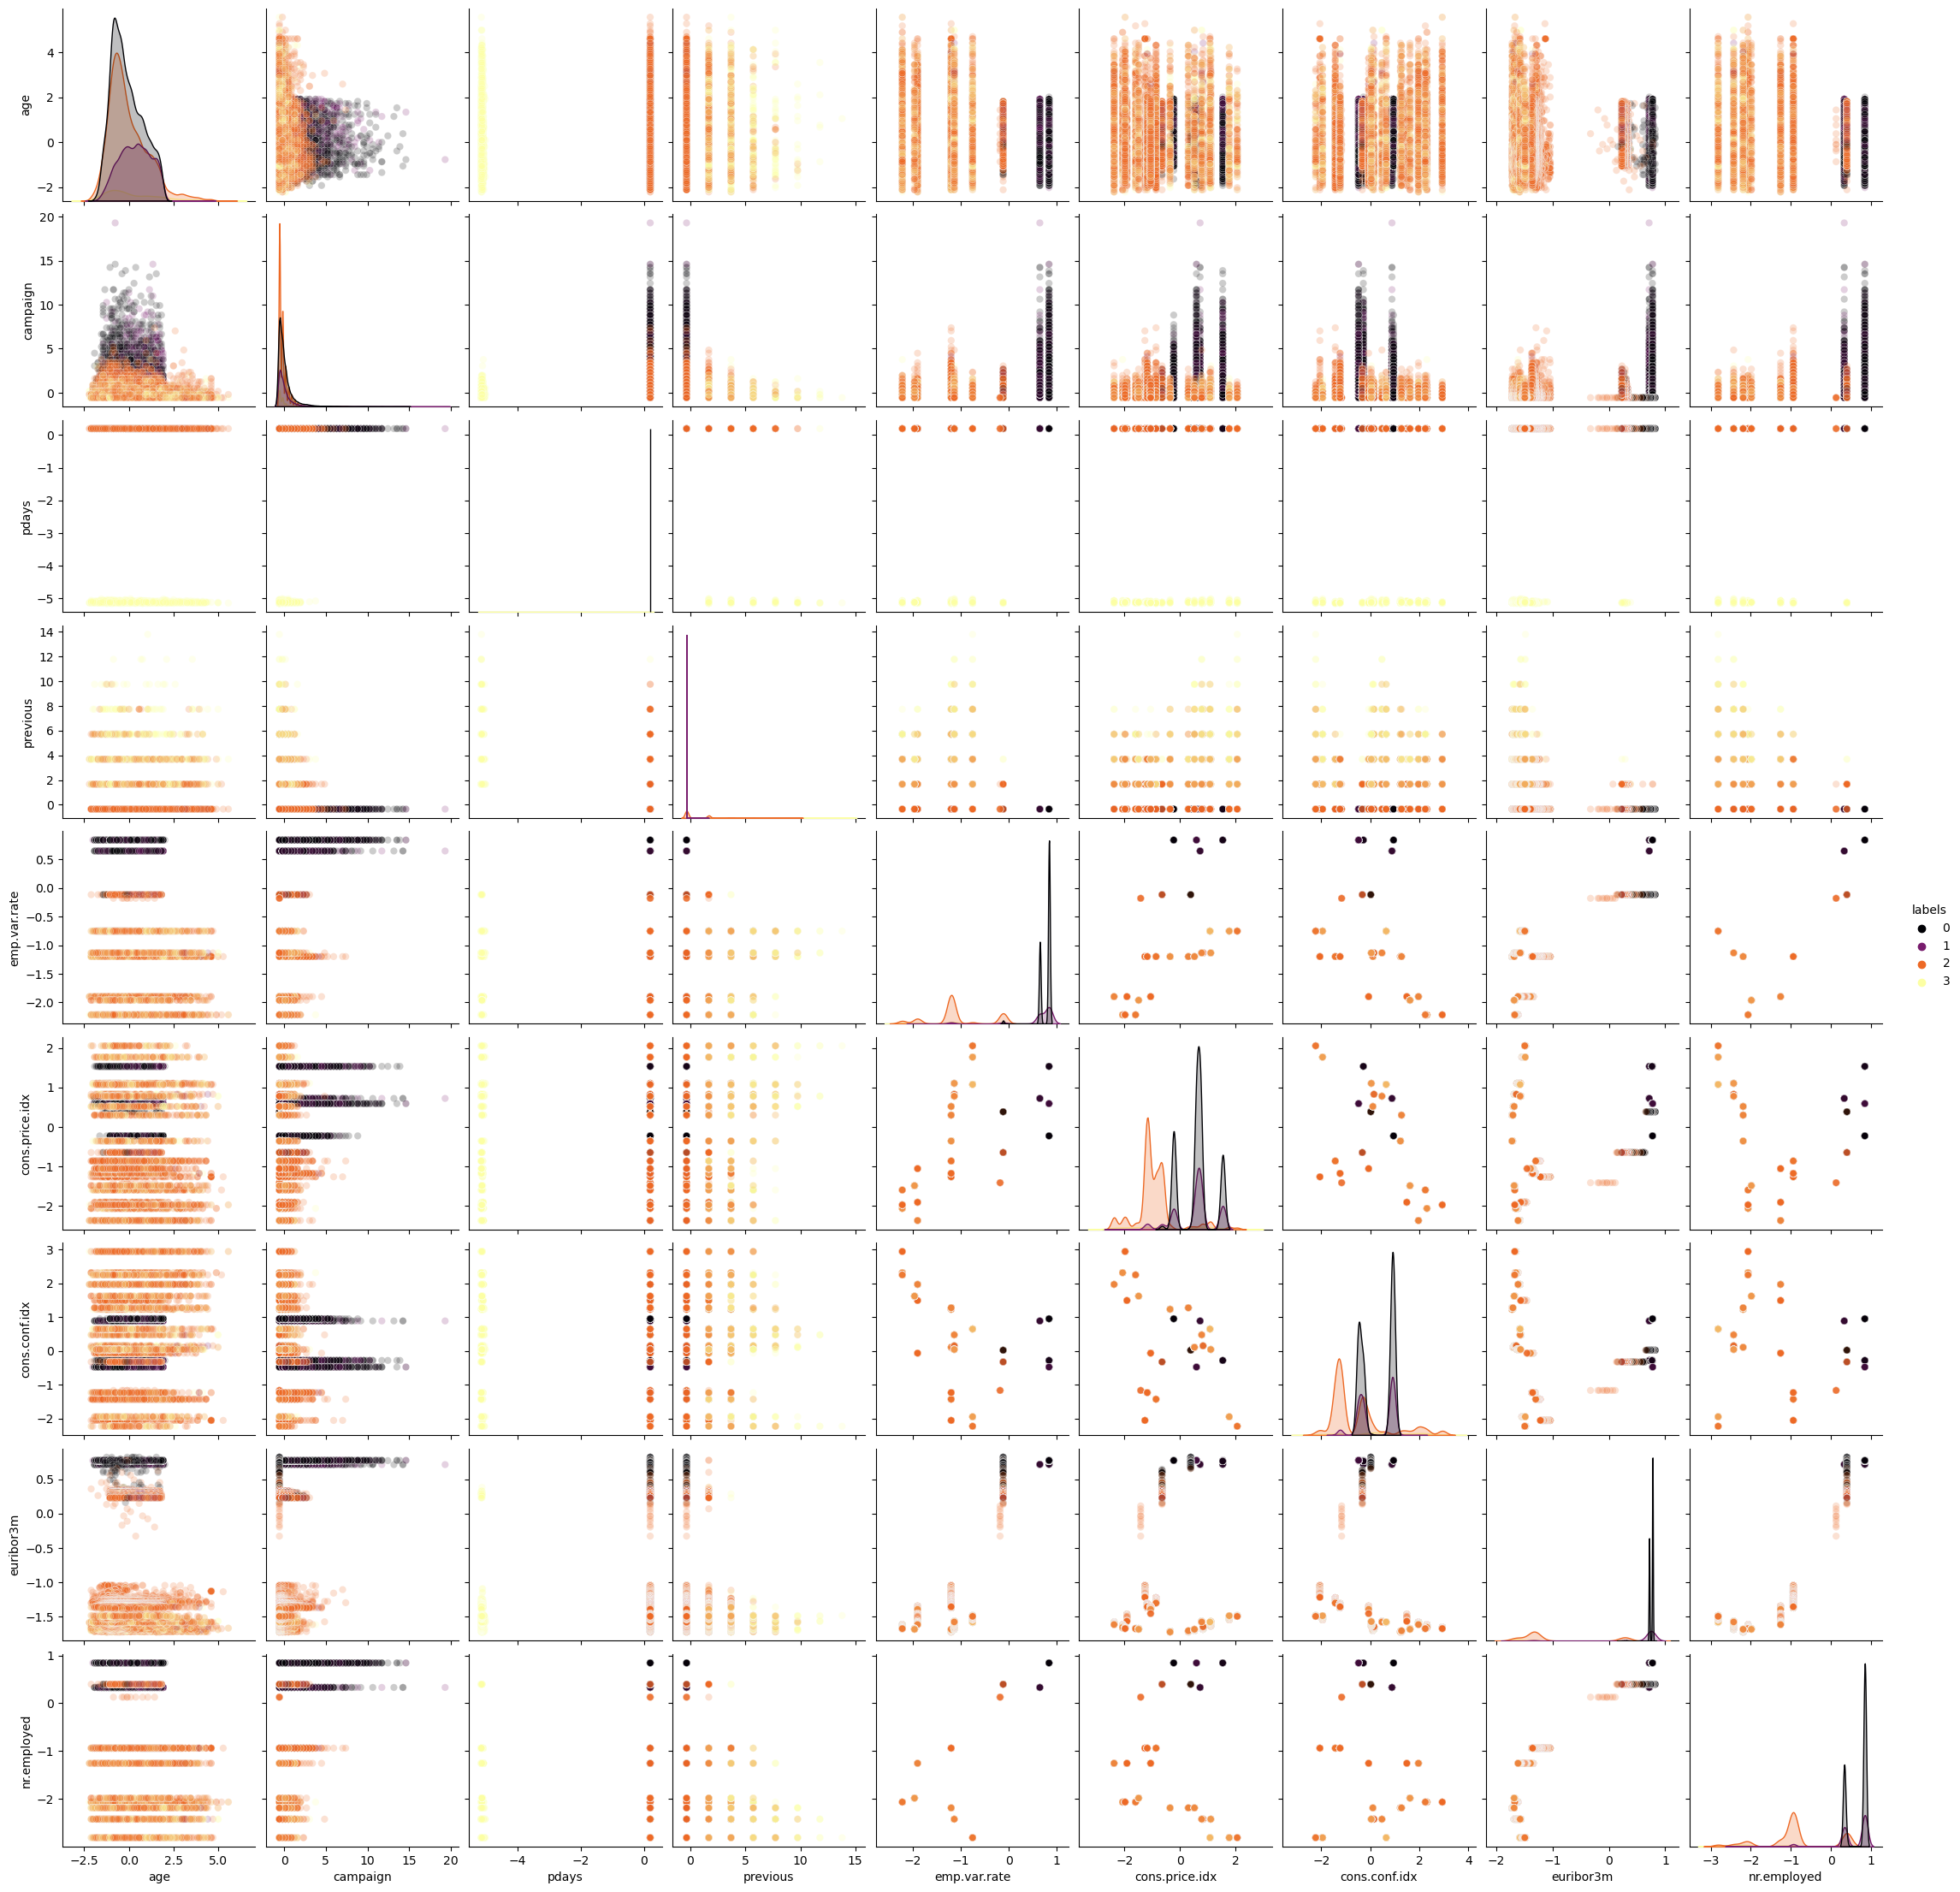

In [20]:
df_plot=pd.concat([df_scaled[numer_vars[:-1]], pd.Series(model.labels_)], axis=1)
df_plot.columns = [*df_scaled[numer_vars[:-1]], 'labels']
sns.pairplot(df_plot, hue='labels', palette='rocket', plot_kws={'alpha':0.2})
plt.show()

In [20]:
HC = AgglomerativeClustering(distance_threshold=5, n_clusters=None, linkage='single', compute_distances=True)
HClust = HC.fit(df_scaled)

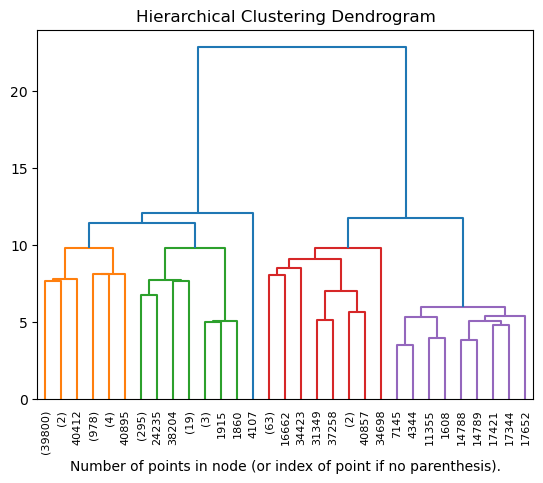

In [30]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html 
# Create linkage matrix and then plot the dendrogram

def plot_dendrogram(model, **kwargs): 

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(HClust, truncate_mode="level", p=5, color_threshold=10)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.xticks(rotation='vertical')
plt.show()